<a href="https://colab.research.google.com/github/jennahgosciak/nyc_fire_risk/blob/main/00_data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
# setup
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import requests
import calendar
import geopandas as gpd
import os.path as os
import scipy.stats
import seaborn.palettes
import seaborn.utils
import sys
from census import Census
from us import states
import http.client, urllib.request, urllib.parse, urllib.error, base64
import config

root= r"C:/Users/Jennah/Desktop/Code/nyc_fire_risk"

# Estimating Fire Casualties in NYC
In NYC, recent fires--like the fire that occurred recently in the Bronx, in which 17 people died--have been devasting. It is important for cities to develop better tools for understanding where such catastrophic events might occur and target these areas for better prevention measures. Specifically, while a building may receive numerous violations from the New York City Housing and Preservation Department (HPD), HPD in turn may not know which buildings to target and when such violations are serious.

I propose a predictive model that calculates the risk of a __catastrophic__ fire using variables not considered in other models.

* I incorporate water and electricity use, as a measure of crowding in the building.
* I use data on past violations in the building, as a measure of a negligent landlord.
* Data on median household income in the surrounding area.
* Population density in the surrounding area.
* Average daily temperature.
* Number of residential building units and building FAR.

# Load data on fire dispatch events
## From January 1st, 2017 through the present
* Create a plot of fire events each year
* Only structural fires are included


In [2]:
# load data on all fire dispate events for structural fires
url_fire_ev = 'https://data.cityofnewyork.us/resource/8m42-w767.csv?$limit=1000000&$where=INCIDENT_CLASSIFICATION_GROUP="Structural%20Fires"'
fire_ev = pd.read_csv(url_fire_ev)
print(fire_ev.shape)

# if false, then we might not have downloaded all data
print(fire_ev.shape[0])
assert fire_ev.shape[0] < 1000000

(456376, 29)
456376


In [3]:
# create month, date, and year variables
fire_ev["incident_date"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.date
fire_ev["incident_month"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.month
fire_ev["incident_day"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.day
fire_ev["incident_year"]= pd.to_datetime(fire_ev["incident_datetime"]).dt.year

fire_ev["incident_md"]= fire_ev[["incident_month", "incident_day"]].astype(str).apply('-'.join, 1)
print("\nFire events by year")
fire_ev["incident_year"].value_counts().sort_index()


Fire events by year


2005    31247
2006    30546
2007    30651
2008    29163
2009    28753
2010    28961
2011    27595
2012    27908
2013    25097
2014    26531
2015    27403
2016    27442
2017    28259
2018    27119
2019    26154
2020    25035
2021     8512
Name: incident_year, dtype: int64

In [60]:
fire_ev.head()

,starfire_incident_id,incident_datetime,alarm_box_borough,alarm_box_number,alarm_box_location,incident_borough,zipcode,policeprecinct,citycouncildistrict,communitydistrict,...,incident_response_seconds_qy,incident_travel_tm_seconds_qy,engines_assigned_quantity,ladders_assigned_quantity,other_units_assigned_quantity,incident_date,incident_month,incident_day,incident_year,incident_md
0,5.001924e+14,2005-01-01T00:07:32.000,QUEENS,9237,N/SVC RD H. HARDING EXPY & 99 ST,QUEENS,11368.0,110.0,21.0,404.0,...,338,236,3,2,2,2005-01-01,1,1,2005,1-1
1,5.001149e+14,2005-01-01T00:14:40.000,MANHATTAN,1493,BWAY & W125 ST\M.L.KING JR BLVD,MANHATTAN,10027.0,26.0,7.0,109.0,...,266,217,2,2,1,2005-01-01,1,1,2005,1-1
2,5.001088e+14,2005-01-01T00:16:29.000,MANHATTAN,878,2 AVE & 53 ST,MANHATTAN,10022.0,17.0,4.0,106.0,...,298,220,5,4,6,2005-01-01,1,1,2005,1-1
3,5.001088e+14,2005-01-01T00:16:29.000,MANHATTAN,878,2 AVE & 53 ST,MANHATTAN,10022.0,17.0,4.0,106.0,...,298,220,5,4,6,2005-01-01,1,1,2005,1-1
4,5.001065e+14,2005-01-01T00:24:58.000,BROOKLYN,653,LAFAYETTE & CLASSON AVES,BROOKLYN,11238.0,79.0,35.0,303.0,...,226,189,3,2,1,2005-01-01,1,1,2005,1-1


## More fire events occur in late November, December, and early January

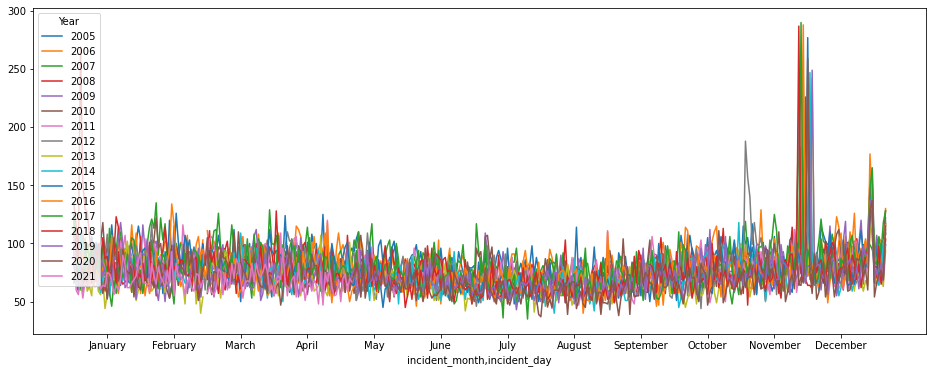

In [5]:
# plot dispatch events over time
# group by month year, day (count)
# make year the first level (pivot level)
fire_ev_plt_df= fire_ev.groupby(["incident_year", "incident_month", "incident_day"]).size().unstack(level = 'incident_year')
fire_ev_plt_df.columns.name= "Year"

fig, ax = plt.subplots(figsize=(13, 6))
fire_ev_plt_df.plot(ax = ax)

# set for month labels
x = [(x, 15) for x in list(range(1,13))]

# create ticks for each month (in the middle, with labels)
plt.xticks(np.arange(15, 365, round(365/12)), labels = [x for x in calendar.month_name if x != ''])
fig.set_size_inches(16, 6)
plt.savefig(os.join(root, "figs/fire_ev_line.pdf"))

# Load data on vacate orders from HPD, due to fire
## From January 1st, 2017 through the present

* Order to repair/vacate orders: https://data.cityofnewyork.us/resource/tb8q-a3ar
* Fire Department building vacate list: https://data.cityofnewyork.us/resource/n5xc-7jfa
* Future work: combine old and new vacate orders? First dataset only has 93 records

In [6]:
url_vac_old = 'https://data.cityofnewyork.us/resource/n5xc-7jfa.csv?$limit=1000000'
vac_old = pd.read_csv(url_vac_old)
print("Size of data:", vac_old.shape)
# format date variable
vac_old["vac_date_orig"]= vac_old["vac_date"].copy()
vac_old["vac_date"]= pd.to_datetime(vac_old["vac_date"]).dt.date
vac_old["vac_year"]= pd.to_datetime(vac_old["vac_date"]).dt.year
# sort data
vac_old.sort_values("vac_year", ascending = True).head()

Size of data: (93, 19)


,vac_date,num,pf,location_1,typ,sf,bor,date_of_lif,area_vac,div,...,latitude,longitude,community_board,community_council,census_tract,bin,bbl,nta,vac_date_orig,vac_year
0,2008-05-19,1234,NaN,INTERVALE,AVE,NaN,BX,NaN,ENTIRE BLDG,6,...,40.828940,-73.894516,3.0,17.0,125.0,2010459.0,2.029740e+09,Morrisania-Melrose ...,5/19/2008,2008
1,2008-05-31,1556,NaN,PARKER,ST,NaN,BX,NaN,BASEMENT,6,...,40.838231,-73.850162,10.0,18.0,202.0,2041683.0,2.039720e+09,Westchester-Unionport ...,5/31/2008,2008
2,2009-03-17,1420,NaN,CROTONA,AVE,NaN,BX,NaN,ENTIRE BUILDING,6,...,40.834290,-73.898082,3.0,16.0,151.0,2009823.0,2.029370e+09,Morrisania-Melrose ...,3/17/2009,2009
3,2009-07-03,414,E,140,ST,NaN,BX,NaN,3rd floor and one room 2nd floor,6,...,40.810042,-73.921112,1.0,8.0,39.0,2000289.0,2.022840e+09,Mott Haven-Port Morris ...,7/3/2009,2009
13,2010-12-09,1443,NaN,TAYLOR,AVE,NaN,BX,NaN,BASEMENT FRONT,7,...,40.836275,-73.866172,9.0,18.0,218.0,2028224.0,2.038990e+09,West Farms-Bronx River ...,12/9/2010,2010


In [7]:
# load vacate orders
url_vac = 'https://data.cityofnewyork.us/resource/tb8q-a3ar.csv?$limit=1000000&$where=primary_vacate_reason="Fire%20Damage"'
vac = pd.read_csv(url_vac)
print(vac.shape)

# if false, then we might not have downloaded all data
print(vac.shape[0])
assert vac.shape[0] < 1000000

(2890, 20)
2890


In [8]:
# create date, month, and year variables
vac["vacate_effective_date2"]= pd.to_datetime(vac["vacate_effective_date"]).dt.date
vac["vacate_effective_month"]= pd.to_datetime(vac["vacate_effective_date"]).dt.month
vac["vacate_effective_day"]= pd.to_datetime(vac["vacate_effective_date"]).dt.day
vac["vacate_effective_year"]= pd.to_datetime(vac["vacate_effective_date"]).dt.year

vac["vacate_effective_md"]= vac[["vacate_effective_month", "vacate_effective_day"]].astype(str).apply('-'.join, 1)

In [9]:
# number of fires per year
vac["vacate_effective_year"].value_counts().sort_index()

2012    283
2013    299
2014    250
2015    253
2016    241
2017    311
2018    312
2019    296
2020    274
2021    314
2022     57
Name: vacate_effective_year, dtype: int64

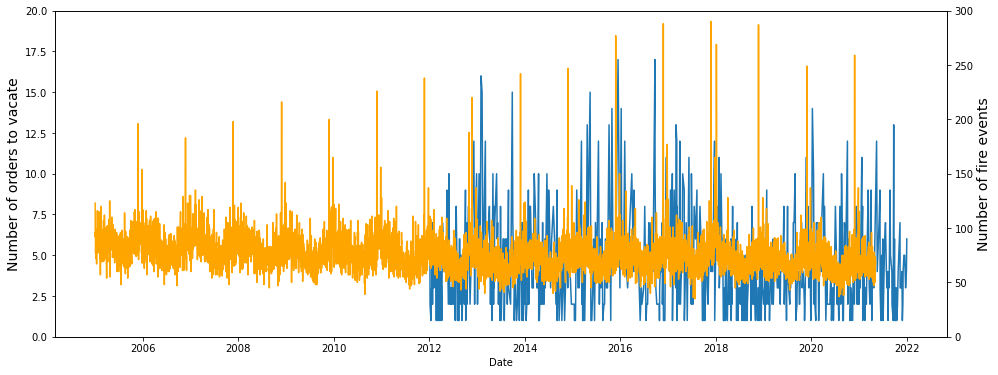

In [10]:
# create plots over time
fig, ax = plt.subplots(figsize=(13, 6))
vac.loc[vac["vacate_effective_year"] < 2022, :].groupby("vacate_effective_date2").size().plot(ax = ax)
ax.set_ylabel("Number of orders to vacate", fontsize=14)
ax.set_ylim([0, 20])

# set second axis
ax2=ax.twinx()
fire_ev.groupby("incident_date").size().plot(ax = ax2, color = "orange")
ax2.set_ylabel("Number of fire events", fontsize=14)
ax2.set_ylim([0, 300])

ax.set_xlabel("Date")
fig.set_size_inches(16, 6)
plt.savefig(os.join(root, "figs/vac_line.pdf"))

In [11]:
## load pluto
pluto= gpd.read_file(os.join(root, "data/nyc_mappluto_21v4_shp/MapPLUTO.shp"))
usecols = ["borough", "bbl", "cd", "ct2010", "zipcode", "address", "bldgclass", "landuse", "ownertype", "ownername",
           "lotarea", "bldgarea", "numbldgs", "numfloors", "unitsres", "unitstotal", "assessland", "assesstot",\
           "exempttot", "yearbuilt", "yearalter1", "yearalter2", "sanborn"]
pluto_df= pd.read_csv(os.join(root, "data/nyc_pluto_21v4_csv/pluto_21v4.csv"),
                      usecols = usecols)
pluto_df.head()

,borough,cd,ct2010,zipcode,address,bldgclass,landuse,ownertype,ownername,lotarea,...,unitsres,unitstotal,assessland,assesstot,exempttot,yearbuilt,yearalter1,yearalter2,bbl,sanborn
0,MN,102.0,61.0,10003.0,42 EAST 12 STREET,R1,2.0,NaN,UNAVAILABLE OWNER,2643.0,...,6.0,6.0,292501.0,6494851.0,5800.0,1900.0,0.0,0.0,1.005638e+09,103 025
1,BK,315.0,392.0,11223.0,2105 OCEAN PARKWAY,A9,1.0,NaN,OCEAN PARKWAY BH 26 LLC,3445.0,...,1.0,1.0,18000.0,178800.0,0.0,2006.0,0.0,0.0,3.071330e+09,314 040
2,BK,315.0,388.0,11223.0,2287 EAST 1 STREET,B3,1.0,NaN,2287E1 LLC,1500.0,...,2.0,2.0,6360.0,59580.0,0.0,1930.0,0.0,0.0,3.071530e+09,314 047
3,QN,408.0,450.0,11432.0,161-26 GRAND CENTRAL PKWY,A5,1.0,NaN,CARLOS RODRIGUEZ,2925.0,...,1.0,1.0,15960.0,39060.0,1440.0,1935.0,0.0,0.0,4.068650e+09,406 042
4,QN,413.0,1617.0,11426.0,244-14 91 AVENUE,A9,1.0,NaN,BASHIR IRFAN,6086.0,...,1.0,1.0,26280.0,44220.0,1440.0,1935.0,2008.0,0.0,4.086580e+09,422 037


In [12]:
# merge to pluto
vac_pluto= pluto.merge(vac, how = "inner", right_on = "bbl", left_on = "BBL")
vac_pluto.head()

,Borough,Block,Lot,CD,BCT2020,BCTCB2020,CT2010,CB2010,SchoolDist,Council,...,council_district,census_tract,bin,bbl,nta,vacate_effective_date2,vacate_effective_month,vacate_effective_day,vacate_effective_year,vacate_effective_md
0,MN,52,21,101,1001300,10013004002,13,1001,02,1,...,1,13,1001040.0,1.000520e+09,Battery Park City-Lower Manhattan ...,2016-11-23,11,23,2016,11-23
1,MN,16,100,101,1031704,10317041000,317.04,1001,02,1,...,1,31704,1083375.0,1.000160e+09,Battery Park City-Lower Manhattan ...,2012-12-14,12,14,2012,12-14
2,MN,237,11,102,1004100,10041004001,41,4001,02,1,...,1,41,1077452.0,1.002370e+09,SoHo-TriBeCa-Civic Center-Little Italy,2018-02-28,2,28,2018,2-28
3,MN,239,11,102,1004100,10041002001,41,2001,02,1,...,1,41,1003119.0,1.002390e+09,SoHo-TriBeCa-Civic Center-Little Italy,2020-01-08,1,8,2020,1-8
4,MN,280,2,103,1000800,10008001001,8,1001,02,1,...,1,8,1003398.0,1.002800e+09,Chinatown ...,2016-12-15,12,15,2016,12-15


In [13]:
# left join from pluto to capture all properties
# use df for space constraints
vac_pluto_df= pluto_df.merge(vac, how = "left", right_on = "bbl", left_on = "bbl", indicator = True)
print(vac_pluto_df["_merge"].value_counts())

# create indicator of fire vacancy based on indicator
vac_pluto_df["vacate_ind"]= np.where(
            vac_pluto_df["_merge"]=="both", 1, 0)

print("\nTab of outcome var (vacate ind)")
print(vac_pluto_df[["vacate_ind", "_merge"]].value_counts())
vac_pluto_df.drop("_merge", axis = 1, inplace = True)

left_only     856408
both            2875
right_only         0
Name: _merge, dtype: int64

Tab of outcome var (vacate ind)
vacate_ind  _merge   
0           left_only    856408
1           both           2875
dtype: int64


(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

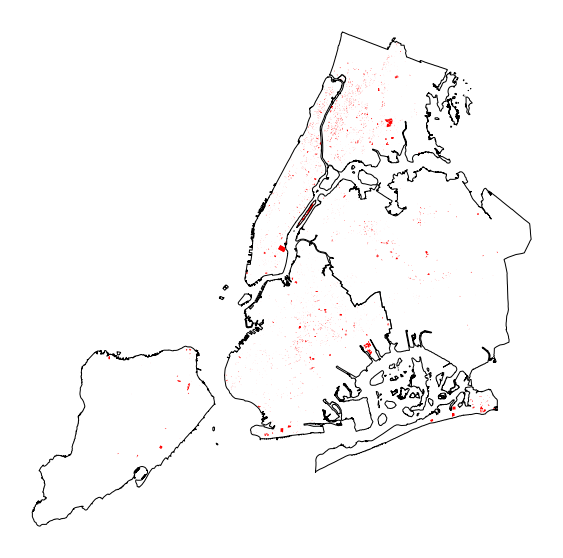

In [14]:
# load boros for background
# plot spatially
boros= gpd.read_file('https://data.cityofnewyork.us/resource/7t3b-ywvw.geojson').set_crs(4326).to_crs(2263)
fig,ax = plt.subplots(figsize=(15,10))

vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

(905464.7390380852, 1075092.8783935553, 112492.5738036365, 280480.09001457837)

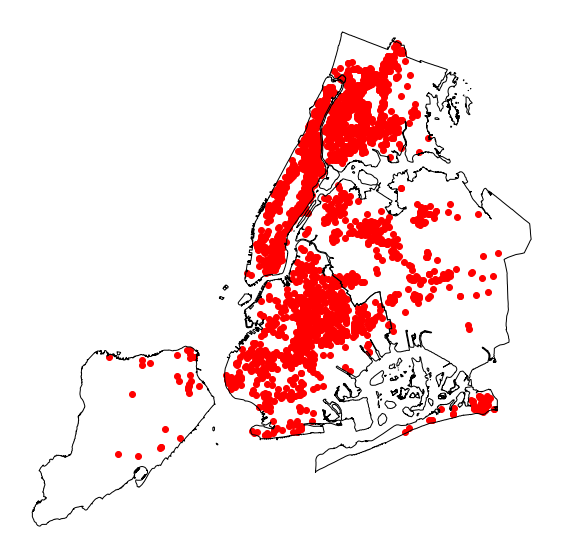

In [15]:
# convert to point data
vac_pluto["geometry"]= vac_pluto["geometry"].representative_point()
fig,ax = plt.subplots(figsize=(15,10))
vac_pluto.plot(ax = ax, facecolor = 'red')
boros.plot(ax = ax, facecolor = "none", edgecolor='black')
ax.axis('off')

### Create heat map of fire vacate orders

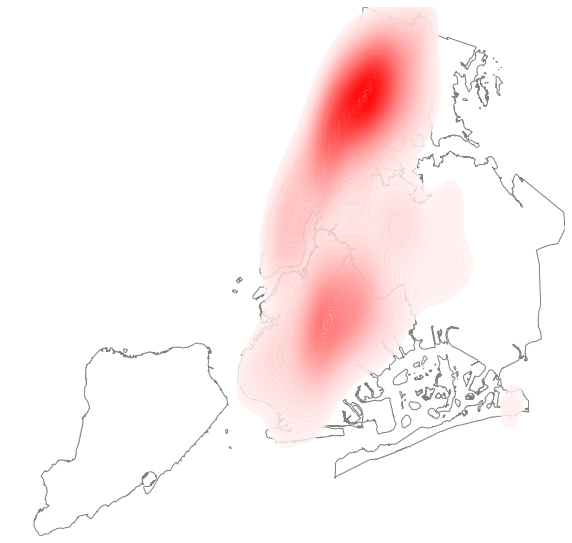

<Figure size 432x288 with 0 Axes>

In [16]:
# weight all the same
vac_pluto["weight"]= 1
# get extent
axis= boros.to_crs(4326).total_bounds
axis

# Calculate the kernel density estimate using gaussian kernels for heat map
# create x,y pairs of long,lat
# heatmaps are used when you have point data that can cluster;
# can see a concentration/elevated levels of events
data = np.c_[vac_pluto.longitude, vac_pluto.latitude]
# weights are all 1, apply kde to data
kde = scipy.stats.gaussian_kde(data.T, bw_method="scott", weights=vac_pluto.weight)

# Compute std along axis
data_std = data.std(axis=0, ddof=1)
# coefficient that multiplies the data covariance matrix to obtain the kernel covariance matrix
bw_x = getattr(kde, "scotts_factor")() * data_std[0]
bw_y = getattr(kde, "scotts_factor")() * data_std[1]
grid_x = grid_y = 100

# create support
x_support = seaborn.utils._kde_support(data[:, 0], bw_x, grid_x, 3, (axis[0], axis[2]))
y_support = seaborn.utils._kde_support(data[:, 1], bw_y, grid_y, 3, (axis[1], axis[3]))
xx, yy = np.meshgrid(x_support, y_support)
# reshape array
# extract values for grid
levels = kde([xx.ravel(), yy.ravel()]).reshape(xx.shape)

# create map for the area w boros
ax = boros.to_crs(4326).plot(facecolor = 'none', edgecolor = 'gray',
                            figsize = (10, 10), alpha = 1)
# create levels
cset = ax.contourf(xx, yy, levels,
    100,
    cmap=seaborn.palettes.blend_palette(('#ffffff10', '#ff0000af'), 100, as_cmap=True),
    antialiased=True,
    alpha = 0.8
)
# hide lowest 4 levels
for i in range(0,5):
    cset.collections[i].set_alpha(0)
    
# remove lines on contour map
for c in cset.collections:
    c.set_edgecolor("face")
    
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
plt.show()
plt.savefig(os.join(root, "figs/heatmap.pdf"), dpi=300, bbox_inches='tight')

# Load census data
* Plot median household income by census tract
* Will load additional variables
* From this [report](): “overcrowded” is more than one person per room, on average, and “severely overcrowded” is more than 1.5 persons per room.
    * Calculate overcrowing based on percentage > 1 person per room
    * Create an indicator using the citywide average

In [27]:
# import census api
c = Census(config.api_key, year=2019)

# store census info in a dictionary
d = {}
           
for count in ['061', '085', '081', '047', '005']:
    # create temp for each county
    # all variables in list
    # store in dict
    temp= c.acs5.get(('NAME', 'B19013_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E',\
                                 'B25014_011E', 'B25014_012E', 'B25014_013E'),\
              {'for': 'tract:*', 'in': 'state:{} county:{}'.format(states.NY.fips, count)})
    
    d.update({(i["county"] + i["tract"]):i for i in temp})
d

{'061025500': {'NAME': 'Census Tract 255, New York County, New York',
  'B19013_001E': 66466.0,
  'B25014_001E': 2030.0,
  'B25014_005E': 0.0,
  'B25014_006E': 0.0,
  'B25014_007E': 0.0,
  'B25014_011E': 56.0,
  'B25014_012E': 83.0,
  'B25014_013E': '31',
  'state': '36',
  'county': '061',
  'tract': '025500'},
 '061022200': {'NAME': 'Census Tract 222, New York County, New York',
  'B19013_001E': 41250.0,
  'B25014_001E': 1459.0,
  'B25014_005E': 0.0,
  'B25014_006E': 0.0,
  'B25014_007E': 0.0,
  'B25014_011E': 9.0,
  'B25014_012E': 12.0,
  'B25014_013E': '22',
  'state': '36',
  'county': '061',
  'tract': '022200'},
 '061001001': {'NAME': 'Census Tract 10.01, New York County, New York',
  'B19013_001E': 81250.0,
  'B25014_001E': 842.0,
  'B25014_005E': 15.0,
  'B25014_006E': 0.0,
  'B25014_007E': 6.0,
  'B25014_011E': 0.0,
  'B25014_012E': 0.0,
  'B25014_013E': '0',
  'state': '36',
  'county': '061',
  'tract': '001001'},
 '061000700': {'NAME': 'Census Tract 7, New York County, New

In [29]:
# create med hh inc df, pull variables for crowding
# create census df, rename cols using dict comprehension
oldcols= ['B19013_001E', 'B25014_001E', 'B25014_005E', 'B25014_006E', 'B25014_007E',\
                                 'B25014_011E', 'B25014_012E', 'B25014_013E']
newcols= ["medhhinc", "occ_total", "gt1_oo", "gt1_5_oo", "gt2_oo", "gt1_ro", "gt1_5_ro", "gt2_ro"]
census= pd.DataFrame.from_dict(d, orient = "index").rename({i:j for i,j in zip(oldcols, newcols)}, axis = 1).reset_index()\
            .rename({"index":"GEOID"}, axis = 1)

# load tract spatial data
tracts= gpd.read_file("https://data.cityofnewyork.us/resource/i69b-3rdj.geojson?$limit=100000")
# recode geoid var for merging
tracts["GEOID"]= np.select(
     [tracts['boro_code'] == "5", tracts['boro_code'] == "1", tracts['boro_code'] == "4",
      tracts['boro_code'] == "3", tracts['boro_code'] == "2"],
    ["085"+tracts["ct2010"], "061"+tracts["ct2010"], "081"+tracts["ct2010"], "047"+tracts["ct2010"],
    "005"+tracts["ct2010"]])

# check no missingness introduced
assert (tracts["GEOID"].isna() == tracts["boro_code"].isna()).all()
print(tracts["GEOID"].unique())
census

['085000900' '061009800' '061010200' ... '085022300' '085020700'
 '085021300']


,GEOID,NAME,medhhinc,occ_total,gt1_oo,gt1_5_oo,gt2_oo,gt1_ro,gt1_5_ro,gt2_ro,state,county,tract
0,061025500,"Census Tract 255, New York County, New York",66466.0,2030.0,0.0,0.0,0.0,56.0,83.0,31,36,061,025500
1,061022200,"Census Tract 222, New York County, New York",41250.0,1459.0,0.0,0.0,0.0,9.0,12.0,22,36,061,022200
2,061001001,"Census Tract 10.01, New York County, New York",81250.0,842.0,15.0,0.0,6.0,0.0,0.0,0,36,061,001001
3,061000700,"Census Tract 7, New York County, New York",184609.0,4391.0,0.0,13.0,47.0,68.0,449.0,49,36,061,000700
4,061010300,"Census Tract 103, New York County, New York",96071.0,1268.0,0.0,7.0,0.0,10.0,74.0,0,36,061,010300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2162,005037504,"Census Tract 375.04, Bronx County, New York",20644.0,1258.0,10.0,0.0,0.0,69.0,0.0,15,36,005,037504
2163,005038301,"Census Tract 383.01, Bronx County, New York",43155.0,1520.0,0.0,0.0,0.0,266.0,142.0,48,36,005,038301
2164,005038302,"Census Tract 383.02, Bronx County, New York",20519.0,2018.0,10.0,0.0,0.0,173.0,91.0,0,36,005,038302
2165,005039500,"Census Tract 395, Bronx County, New York",29000.0,1586.0,0.0,22.0,0.0,100.0,74.0,0,36,005,039500


In [30]:
# merge tracts to census data
tracts_census= tracts.merge(census, how = "outer", on = "GEOID")
tracts_census

# recode neg. values to missing
tracts_census['Median HH Inc']= np.where(
     tracts_census['medhhinc'] < 0, np.nan,
    tracts_census['medhhinc'])

# check recoding
assert (tracts_census["Median HH Inc"].isna() == (tracts_census['medhhinc'].isna() | (tracts_census['medhhinc'] < 0))).all()

In [31]:
# create indicator for overcrowding variabel
tracts_census["sum_crowding"]= tracts_census[["gt1_oo", "gt1_5_oo", "gt2_oo", "gt1_ro", "gt1_5_ro", "gt2_ro"]].sum(axis = 1)
tracts_census["per_crowding"]= tracts_census.loc[:, "sum_crowding"].div(tracts_census.loc[:, "occ_total"]).fillna(0)

tracts_census["crowding_ind"]= np.where(
            tracts_census["per_crowding"]>=tracts_census["per_crowding"].mean(), 1, 0)
print("NYC Average from 2014-2019 ACS:", tracts_census["per_crowding"].mean())
print("\nCrosstab variable construction:")
print(tracts_census[["sum_crowding", "occ_total", "per_crowding"]].value_counts().sample(frac=0.025))
print("\nCheck indicator construction:")
print(tracts_census[["crowding_ind", "per_crowding"]].sample(frac=0.025).value_counts())

NYC Average from 2014-2019 ACS: 0.08532922044839054

Crosstab variable construction:
sum_crowding  occ_total  per_crowding
71.0          1384.0     0.051301        1
571.0         2066.0     0.276379        1
70.0          782.0      0.089514        1
104.0         1424.0     0.073034        1
17.0          3561.0     0.004774        1
320.0         2695.0     0.118738        1
93.0          1164.0     0.079897        1
130.0         1569.0     0.082855        1
9.0           2488.0     0.003617        1
63.0          848.0      0.074292        1
100.0         1371.0     0.072939        1
122.0         2760.0     0.044203        1
21.0          1082.0     0.019409        1
122.0         1026.0     0.118908        1
0.0           128.0      0.000000        1
24.0          1939.0     0.012378        1
119.0         841.0      0.141498        1
216.0         1174.0     0.183986        1
70.0          1069.0     0.065482        1
51.0          1538.0     0.033160        1
0.0           436

C:\Users\Jennah\AppData\Local\Temp/ipykernel_35500/565480215.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  tracts_census["sum_crowding"]= tracts_census[["gt1_oo", "gt1_5_oo", "gt2_oo", "gt1_ro", "gt1_5_ro", "gt2_ro"]].sum(axis = 1)


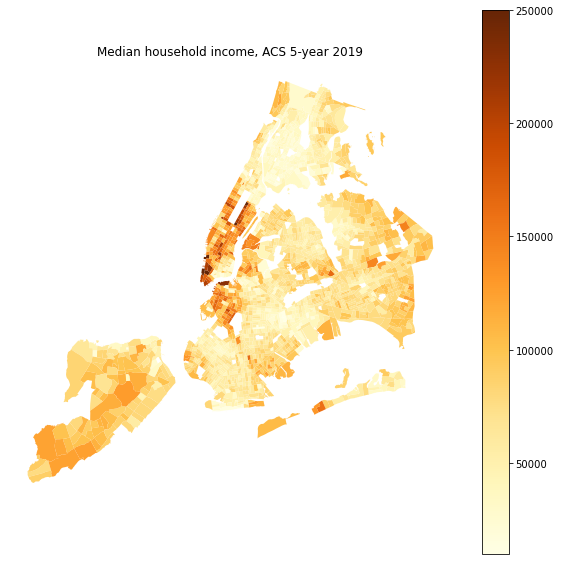

In [32]:
# plot median household income by census tract
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "Median HH Inc", cmap = "YlOrBr", ax = ax, legend=True)
plt.title("Median household income, ACS 5-year 2019")
ax.axis('off')
plt.show()

(-74.28337047811618, -73.67222994890716, 40.475164048167265, 40.93650271594718)

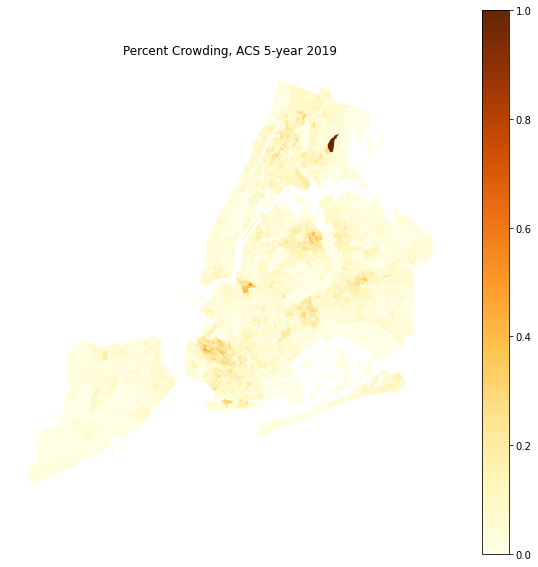

In [33]:
# plot percent crowding
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.plot(column= "per_crowding", cmap = "YlOrBr", ax = ax, legend = True)
plt.title("Percent Crowding, ACS 5-year 2019")
ax.axis('off')

In [34]:
print(tracts_census.loc[tracts_census["per_crowding"] > 0.7, ["occ_total", "gt1_ro", "gt1_oo"]])
# outlier is small total number of properties
assert (tracts_census.loc[tracts_census["per_crowding"] > 0.7, "occ_total"].values == 5)

      occ_total  gt1_ro  gt1_oo
1968        5.0     5.0     0.0


(-74.28337047811618, -73.67222994890716, 40.475164048167265, 40.93650271594718)

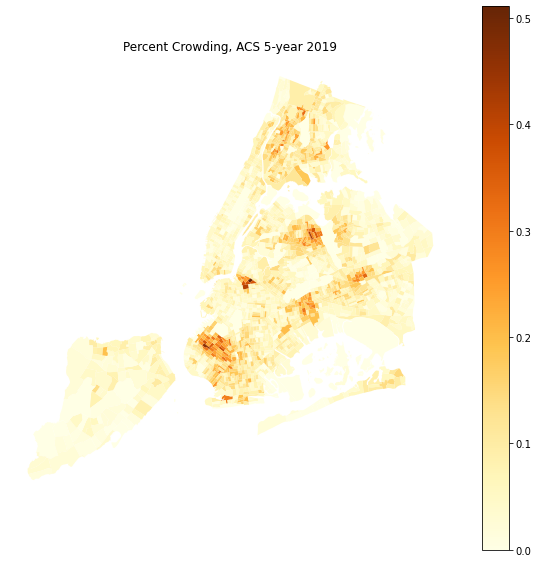

In [35]:
# plot percent crowding, drop outlier for better visualization
fig, ax= plt.subplots(figsize = (10, 10))
tracts_census.loc[tracts_census["per_crowding"] <= 0.7, :]\
            .plot(column= "per_crowding", cmap = "YlOrBr", ax = ax, legend = True)
plt.title("Percent Crowding, ACS 5-year 2019")
ax.axis('off')

In [36]:
# create county variable
vac_pluto_df["county"]= np.select(
     [vac_pluto_df['borough'] == "SI",
      vac_pluto_df['borough'] == "MN",
      vac_pluto_df['borough'] == "QN",
      vac_pluto_df['borough'] == "BK",
      vac_pluto_df['borough'] == "BX"],
    ["085", "061", "081", "047", "005"])
print("\nCheck coding of county from borough:")
print(vac_pluto_df[["county", "borough"]].value_counts())
assert (vac_pluto_df["county"].isna() == vac_pluto_df["borough"].isna()).all()

# create geoid variable
vac_pluto_df["GEOID"]= vac_pluto_df["county"] + vac_pluto_df["ct2010"].apply(lambda x: "%.2f" % x)\
                            .str.replace(".", "", regex = False)\
                            .str.pad(width = 6, side = "left", fillchar = "0")
vac_pluto_df["GEOID"]= np.where(
        vac_pluto_df["ct2010"].isna(), np.nan, vac_pluto_df["GEOID"])
print("\nCheck coding of GEOID from county and ct2010:")
print(vac_pluto_df[["GEOID", "county", "ct2010"]].sample(frac=0.05).value_counts())
assert (vac_pluto_df["GEOID"].isna() == vac_pluto_df["ct2010"].isna()).all()

# check per missing census tract
print("\nPercent missing census tract:", vac_pluto_df["ct2010"].isna().mean())


Check coding of county from borough:
county  borough
081     QN         324698
047     BK         276930
085     SI         125076
005     BX          89803
061     MN          42776
dtype: int64

Check coding of GEOID from county and ct2010:
GEOID      county  ct2010 
085022600  085     226.00     171
085017700  085     177.00     141
081088400  081     884.00     132
085013800  085     138.00     128
085007000  085     70.00      127
                             ... 
005021900  005     219.00       1
061015601  061     156.01       1
005022101  005     221.01       1
061020101  061     201.01       1
047105801  047     1058.01      1
Length: 2070, dtype: int64

Percent missing census tract: 0.002081968338719607


In [44]:
vac_census= vac_pluto_df.merge(tracts_census.drop("geometry", axis = 1), how = "outer", on = "GEOID", indicator = True,\
                              validate= "many_to_one")
print("Check merge")
print(vac_census["_merge"].value_counts())
# make sure the three cases are missing median hhinc (no pop there)
assert vac_census.loc[vac_census["_merge"]=="right_only", "Median HH Inc"].isna().all()

Check merge
both          857471
left_only       1812
right_only         3
Name: _merge, dtype: int64


In [45]:
print("Unmerged values are evenly distributed; random checking suggests that these don't have census data associated w/ them")
print("We could geocode addresses to improve accuracy")
print(vac_census.loc[vac_census["_merge"]=="left_only", "borough"].value_counts())
vac_census.drop(vac_census.loc[vac_census["_merge"]=="right_only", :].index, axis = 0, inplace = True)
vac_census.drop("_merge", axis = 1, inplace = True)

# check there are no missing bbl values
assert vac_census["bbl"].isna().sum() == 0

Unmerged values are evenly distributed; random checking suggests that these don't have census data associated w/ them
We could geocode addresses to improve accuracy
BK    661
QN    431
MN    364
BX    219
SI    137
Name: borough, dtype: int64


## Load data on electricity and water usage
* [2020 data](https://data.cityofnewyork.us/resource/usc3-8zwd.csv)
* [2019 data](https://data.cityofnewyork.us/resource/wcm8-aq5w.csv)
* [2018 data](https://data.cityofnewyork.us/resource/4tys-3tzj.csv)
* [2017 data](https://data.cityofnewyork.us/resource/4t62-jm4m.csv)

In [46]:
# store urls
url_2020= "https://data.cityofnewyork.us/resource/usc3-8zwd.csv?$limit=100000"
url_2019= "https://data.cityofnewyork.us/resource/wcm8-aq5w.csv?$limit=100000"
url_2018= "https://data.cityofnewyork.us/resource/4tys-3tzj.csv?$limit=100000"
url_2017= "https://data.cityofnewyork.us/resource/4t62-jm4m.csv?$limit=100000"

# load and append data from each year
urls= [url_2017, url_2018, url_2019, url_2020]
cols= [["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources", "multifamily_housing_number",\
                                        "multifamily_housing_total"],\
      ["property_id", "year_ending",\
                                      "property_name", "nyc_borough_block_and_lot_bbl",\
                                      "occupancy", "year_built", "number_of_buildings",\
                                       "water_use_all_water_sources_kgal", "multifamily_housing_number_of_bedrooms",\
                                        "multifamily_housing_total_number_of_residential_living_units"]]
# read in all data files using lc, combine across the rows
dfs= [pd.read_csv(urls[i], usecols = cols[i]) for i in range(0, 4)]
dfs

[       property_id              year_ending  \
 0          4593574  2017-12-31T00:00:00.000   
 1          6224375  2017-12-31T00:00:00.000   
 2          2967701  2017-12-31T00:00:00.000   
 3          4898531  2017-12-31T00:00:00.000   
 4          2917939  2017-12-31T00:00:00.000   
 ...            ...                      ...   
 34681      4047752  2017-12-31T00:00:00.000   
 34682      6682473  2017-12-31T00:00:00.000   
 34683      6682474  2017-12-31T00:00:00.000   
 34684      6682477  2017-12-31T00:00:00.000   
 34685      2819133  2017-12-31T00:00:00.000   
 
                                 property_name  nyc_borough_block_and_lot  \
 0                       The Argonaut Building                 1010287502   
 1                             Operative Cakes  2-00560-0062;2-05560-0062   
 2              Cathedral Preparatory Seminary               4-01872-0007   
 3                             The Nomad Hotel               1-00829-0050   
 4                      10 West 27 St

In [47]:
# make names of columns uniform
dfs[0].columns = cols[0]
dfs[1].columns = cols[0]
dfs[2].columns = cols[0]
dfs[3].columns = cols[0]

# concatenate along rows (i.e. append data from each year)
df_ew= pd.concat(dfs, axis = 0)
df_ew

,property_id,year_ending,property_name,nyc_borough_block_and_lot,occupancy,year_built,number_of_buildings,water_use_all_water_sources,multifamily_housing_number,multifamily_housing_total
0,4593574,2017-12-31T00:00:00.000,The Argonaut Building,1010287502,1909,1,95,NaN,NaN,3635.5
1,6224375,2017-12-31T00:00:00.000,Operative Cakes,2-00560-0062;2-05560-0062,1973,2,100,NaN,NaN,116.0
2,2967701,2017-12-31T00:00:00.000,Cathedral Preparatory Seminary,4-01872-0007,1963,1,100,NaN,NaN,102.9
3,4898531,2017-12-31T00:00:00.000,The Nomad Hotel,1-00829-0050,1999,1,85,NaN,NaN,10762.6
4,2917939,2017-12-31T00:00:00.000,10 West 27 Street Corp,1-00828-0053,1994,1,100,NaN,NaN,790.1
...,...,...,...,...,...,...,...,...,...,...
28062,17286197,ACF - 129th St Residence - 109 West 129th St: ...,2020-12-31T00:00:00.000,1-01914-0026,1920,1,100,Not Available,Not Available,Not Available
28063,17298485,110-31 Merrick Boulevard,2020-12-31T00:00:00.000,4102700059,1997,1,100,Not Available,Not Available,Not Available
28064,17298486,110-31A Merrick Boulevard,2020-12-31T00:00:00.000,4102700047,1997,1,100,Not Available,Not Available,Not Available
28065,17321529,402 EAST 78 STREET,2020-12-31T00:00:00.000,1014720046,1910,1,100,52,39,1788.6


In [48]:
# text formatting of bbl
df_ew.loc[:, "bbl"]= df_ew.iloc[:, 3].str.replace("[A-z]{1}[0-9]{3}-", "", regex = True)
df_ew.loc[:, "bbl"]= df_ew.loc[:, "bbl"].str.replace("-", "").str.replace(" ", ";")\
                        .str.replace("(?<=[0-9]{10})/", ";", regex = True)\
                        .str.replace("/", "")\
                        .str.replace(",", ";")\
                        .str.replace(":", ";")\
                        .str.replace("and", ";")\
                        .str.replace("&", ";")\
                        .str.replace("NotAvailable", "")\
                        .str.replace("multiple", "")
df_ew.loc[:, "bbl"]

0                   1010287502
1        2005600062;2055600062
2                   4018720007
3                   1008290050
4                   1008280053
                 ...          
28062               1019140026
28063               4102700059
28064               4102700047
28065               1014720046
28066               4102700057
Name: bbl, Length: 117082, dtype: object

In [49]:
# need to split bbl into several columns
max_num= int(df_ew["bbl"].str.count(";").max())
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]]= df_ew["bbl"].str.split(pat= ";", n=-1, expand = True)
df_ew[["bbl" + str(i) for i in range(0, (max_num + 1))]].head()

,bbl0,bbl1,bbl2,bbl3,bbl4,bbl5,bbl6,bbl7,bbl8,bbl9,...,bbl32,bbl33,bbl34,bbl35,bbl36,bbl37,bbl38,bbl39,bbl40,bbl41
0,1010287502,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2005600062,2055600062,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,4018720007,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,1008290050,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,1008280053,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [50]:
# reshape and reformat bbl column
# pivot data long using melt
cols = [x for x in df_ew.columns if x not in ["bbl" + str(i) for i in range(0, max_num)] + ["bbl"]]
cols

# melt pivots data long
df_ewlong= pd.melt(df_ew.drop("bbl", axis = 1), id_vars=cols,var_name='bbl_num', value_name='bbl')
# recode comparison
print(df_ewlong[["bbl", "nyc_borough_block_and_lot"]].dropna().loc[(df_ewlong["bbl"].dropna()).map(len) > 10, :])

df_ewlong= df_ewlong[(df_ewlong["bbl"].notna()) | (df_ewlong["bbl"].isna() & \
                                                         df_ewlong["bbl_num"] == "bbl0")].drop_duplicates()

                  bbl                          nyc_borough_block_and_lot
61      0004033410037                                    0004-03341-0037
319       1005800065.                                      1-00580-0065.
2061      10193100006                                      1-01931-00006
4018      1005800065.                                      1-00580-0065.
4290      20028110024                                        20028110024
...               ...                                                ...
482954    05006200200  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...
516925    30605000019  3-06050-0051; 3-06050-0059; 3-06050-00019; 3-0...
541896    30605000019    3060500051; 3060500059; 30605000019; 3060500015
569611    30605000019    3060500051; 3060500059; 30605000019; 3060500015
717118    05006200300  05-00620-0001; 05-00620-0100; 05-00620-0200; 0...

[69 rows x 2 columns]


In [51]:
# drop these values, not useful
df_ewlong= df_ewlong.drop(df_ewlong.loc[(df_ewlong["bbl"].str.len() != 10) | \
                (df_ewlong["bbl"] == "Code9Code9") | \
                (df_ewlong["bbl"] == "Not Available") | \
                (df_ewlong["bbl"] == "XXXXXXXXXX"), :].index, axis = 0)

In [52]:
# clean total housing units data
df_ewlong.loc[(df_ewlong["multifamily_housing_total"] == "0") | \
              (df_ewlong["multifamily_housing_total"] == "Not Available"), "multifamily_housing_total"]= ""
df_ewlong["multifamily_housing_total_orig"]= df_ewlong["multifamily_housing_total"].copy()
df_ewlong["multifamily_housing_total"]= pd.to_numeric(df_ewlong["multifamily_housing_total"])

df_ewlong[["multifamily_housing_total", "multifamily_housing_total_orig"]].sample(frac=0.05).value_counts()

multifamily_housing_total  multifamily_housing_total_orig
0.0                        0.0                               8
2538.9                     2538.9                            3
6980.3                     6980.3                            3
1785.1                     1785.1                            2
1473.7                     1473.7                            2
                                                            ..
2358.3                     2358.3                            1
2359.4                     2359.4                            1
2360.1                     2360.1                            1
2364.4                     2364.4                            1
4095889.9                  4095889.9                         1
Length: 3258, dtype: int64

In [53]:
# calculate water usage per unit (can also be calculated for comparison using resunits from pluto)
df_ewlong["water_num"]= pd.to_numeric(df_ewlong["water_use_all_water_sources"].str.replace("Not Available", ""))
# fill missing values with 0s
df_ewlong["pwater_num"]= df_ewlong["water_num"].div(df_ewlong["multifamily_housing_total"].astype(float), \
                                                       fill_value = 0).fillna(0)

In [54]:
# merge to pluto and main df
print(df_ewlong[["bbl","pwater_num", "water_num", "multifamily_housing_total"]].head())
# need to convert bbl to string
vac_census["bbl"]= vac_census["bbl"].astype(str).str.replace(".0", "", regex = False)
assert (vac_census["bbl"].str.len() == 10).all()
assert (df_ewlong["bbl"].str.len() == 10).all()

vac_ew= pd.merge(vac_census, df_ewlong, how = "left", on = "bbl", indicator = True)

          bbl  pwater_num  water_num  multifamily_housing_total
0  1010287502         0.0        NaN                     3635.5
1  2005600062         0.0        NaN                      116.0
2  4018720007         0.0        NaN                      102.9
3  1008290050         0.0        NaN                    10762.6
4  1008280053         0.0        NaN                      790.1


In [55]:
print(vac_ew.shape)
# check size of unmerged buildings (small buildings under 10,000 sq. ft. for gov't buildings
# and 25,000 shouldn't be merging)
print(vac_ew.loc[vac_ew["property_id"].notna(), :].shape)
print(vac_ew.loc[vac_ew["property_id"].isna(), :].shape)
print(vac_ew.loc[(vac_ew["property_id"].isna()) & \
                       (vac_ew["bldgarea"] < 25000), "bldgarea"].shape)

print("\nMerge rate:")
print(vac_ew["_merge"].value_counts())
# assert there are no values unmerged on rhs
assert vac_ew.loc[vac_ew["_merge"]=="right_only"].shape[0]==0
vac_ew.drop("_merge", axis = 1, inplace = True)

(939431, 93)
(107179, 93)
(832252, 93)
(828287,)

Merge rate:
left_only     832252
both          107179
right_only         0
Name: _merge, dtype: int64


## Load HPD Housing Code Violations
* Data saved on the [NYC Open Data Portal](https://data.cityofnewyork.us/resource/wvxf-dwi5.csv)
* Load Class C Violations (Class C are most severely hazardous)
* All violation filings since January 1st, 2017

In [57]:
import psycopg2 as psy
# load furman db
connection = psy.connect(
    host="fcdata.c7h93yqbqnvu.us-east-1.rds.amazonaws.com",
    port=5432,
    user = "furmandata",
    password = config.furman_pwd,
    database = "fcdata")
cursor = connection.cursor()

In [58]:
viol_summary= pd.read_sql("""SELECT violation_class, bbl, Count(*) FROM hpd_violations
                            WHERE inspection_date >= '2017-01-01'
                            GROUP BY violation_class, bbl;""", con=connection)
viol_summary= viol_summary.drop(viol_summary[(viol_summary["bbl"]=='0         ') | \
                                             (viol_summary["bbl"].isna())].index, axis = 0)
assert (viol_summary["bbl"].str.len() == 10).all()
viol_summary.head()

,violation_class,bbl,count
1,A,1000070038,1
2,A,1000077501,15
3,A,1000077502,1
4,A,1000080039,1
5,A,1000100033,1


In [ ]:
# convert bbl to string
viol_summary["bbl"]= viol_summary["bbl"].astype(str).str.replace(".0", "", regex = False)
viol_summary= viol_summary.rename({"count":"num_viol"}, axis = 1)

In [ ]:
# pivot data wider
viol_wide= viol_summary.pivot(index='bbl', columns='violation_class', values = 'num_viol').fillna(0).reset_index()
viol_wide.head()

In [ ]:
# check length of bbl prior to merging
assert (vac_ew["bbl"].str.len() == 10).all()
assert (viol_wide["bbl"].str.len() == 10).all()
vac_viol= pd.merge(vac_ew, viol_wide, how = "left", on = "bbl", indicator = True)
print("Merge rate:")
print(vac_viol["_merge"].value_counts())
vac_viol.drop("_merge", axis = 1, inplace = True)

In [ ]:
print("Average number of class C violations:", vac_viol["C"].mean())
print("Average number of class C violations (among buildings w fire vacate orders):", \
      vac_viol.loc[vac_viol["vacate_ind"] == 1, "C"].mean())

# replace na values with 0
viol_cols= ["A", "B", "C", "I"]
vac_viol.loc[:, viol_cols]= vac_viol.loc[:, viol_cols].fillna(0)
# rename cols
vac_viol.rename({i:j for i,j in zip(viol_cols, ["numviol_" + x for x in viol_cols])}, axis = 1, inplace = True)
vac_viol.loc[:, ["numviol_" + x for x in ["A", "B", "C", "I"]]]

## Save cleaned analytic file
* Create version of data file with only selected variables that can be used for the analysis

In [ ]:
vac_viol["pwater_num_na"]= np.where(
    vac_viol["pwater_num"].isna() | np.isinf(vac_viol["pwater_num"]) | vac_viol["pwater_num"] == 0, 1, 0)
vac_viol["pwater_num"]= np.where(
    vac_viol["pwater_num"].isna() | np.isinf(vac_viol["pwater_num"]), 0, vac_viol["pwater_num"])
print(vac_viol[["pwater_num_na", "pwater_num"]].value_counts())

analysis_vars= ["bbl", "unitsres", "yearbuilt", "medhhinc", "assessland",\
                    "crowding_ind", "pwater_num", "pwater_num_na", "exempttot", "numviol_C", "vacate_ind"]
print(vac_viol.columns)
df_analysis= vac_viol.loc[:, analysis_vars]

In [ ]:
# export
df_analysis.to_csv(os.join(root, "data/analysis_file.csv"))